## Accidents cyclists in Gdansk and Cracow in 2019

Bicycle accidents downloaded from sewik.pl

#### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium as fl
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import shapely
from pyproj import Proj, transform
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface
from shapely.geometry.polygon import Polygon
from branca.colormap import linear

#### Definition

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(18,10)

#### Loading the data

In [3]:
data = pd.read_csv('data/bike_accidents.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         789 non-null    int64  
 1   Time               789 non-null    object 
 2   Adres              789 non-null    object 
 3   Miasto             789 non-null    object 
 4   dlug               789 non-null    float64
 5   szer               789 non-null    float64
 6   Miejsce.zdarzenie  789 non-null    int64  
 7   Rodzaj.zdarzenia   789 non-null    int64  
 8   ucz1               789 non-null    int64  
 9   ucz1_plec          789 non-null    int64  
 10  ucz1_pod_wplywem   789 non-null    int64  
 11  Ucz1DOB            789 non-null    int64  
 12  ucz2               789 non-null    int64  
 13  ucz2_plec          789 non-null    int64  
 14  ucz2_pod_wplywem   789 non-null    int64  
 15  Ucz2DOB            789 non-null    int64  
 16  dzielnica          789 non

In [5]:
data.rename(columns={'Adres':'Adress','Miasto':'City','dlug':'lon','szer':'lat', 'dzielnica':'District',
                    'Miejsce.zdarzenie':'Place_of_the_incident', 'Rodzaj.zdarzenia':'Type_of_incident'}, inplace=True)

In [6]:
data.City = data.City.apply(lambda x: 'Gdansk' if x=='Gdańsk' else 'Cracow')

In [7]:
data.District[data.City=='Gdansk'].unique()

array(['Anio³ki', 'Oliwa', 'Zaspa-Rozstaje', 'Wrzeszcz Górny',
       '\x8cródmie\x9ccie', 'Przymorze Ma³e', 'Wrzeszcz Dolny', 'Siedlce',
       'Przymorze Wielkie', '¯abianka-Wejhera-Jelitkowo-Tysi¹clecia',
       'Orunia-\x8cw. Wojciech-Lipce', 'Jasieñ', 'Strzy¿a',
       'Uje\x9ccisko-£ostowice', 'Piecki-Migowo', 'Osowa', 'Rudniki',
       'Brze\x9fno', 'Orunia Górna - Gdañsk Po³udnie', 'M³yniska',
       'Che³m', 'Kokoszki', 'Przeróbka', 'Letnica', 'Nowy Port',
       'Zaspa-M³yniec', 'Suchanino', 'Stogi'], dtype=object)

In [8]:
data.District[data.City=='Cracow'].unique()

array(['Dębniki', 'Prądnik Biały', 'Stare Miasto', 'Podgórze',
       'Grzegórzki', 'Prądnik Czerwony', 'Bieńczyce', 'Krowodrza',
       'Zwierzyniec', 'Nowa Huta', 'Łagiewniki-Borek Fałęcki',
       'Swoszowice', 'Czyżyny', 'Bronowice', 'Podgórze Duchackie',
       'Bieżanów-Prokocim', 'Mistrzejowice', 'Wzgórza Krzesławickie'],
      dtype=object)

In [9]:
district_dict = {'Anio³ki':'Aniolki', 
                 'Wrzeszcz Górny':'Wrzeszcz Gorny',
                 '\x8cródmie\x9ccie':'Srodmiescie',
                 'Przymorze Ma³e':'Przymorze Male',
                 '¯abianka-Wejhera-Jelitkowo-Tysi¹clecia':'Zabianka - Jelitkowo',
                 'Orunia-\x8cw. Wojciech-Lipce':'Orunia Dolna',
                 'Jasieñ':'Jasien',
                 'Strzy¿a':'Strzyza',
                 'Uje\x9ccisko-£ostowice':'Ujescisko - Lostowice', 
                 'Brze\x9fno':'Brzezno', 
                 'Orunia Górna - Gdañsk Po³udnie':'Gdansk Poludnie', 
                 'M³yniska':'Mlyniska',
                 'Che³m':'Chelm', 
                 'Przeróbka':'Przerobka', 
                 'Zaspa-M³yniec':'Zaspa - Mlyniec',
                 'Dębniki':'Debniki', 
                 'Prądnik Biały':'Pradnik Bialy', 
                 'Podgórze':'Podgorze',
                 'Grzegórzki':'Grzegorzki', 
                 'Prądnik Czerwony':'Pradnik Czerwony', 
                 'Bieńczyce':'Bienczyce', 
                 'Łagiewniki-Borek Fałęcki':'Lagiewniki - Borek Falecki',
                 'Czyżyny':'Czyzyny', 
                 'Podgórze Duchackie':'Podgorze Duchackie',
                 'Bieżanów-Prokocim':'Biezanow - Prokocim', 
                 'Wzgórza Krzesławickie':'Wzgorza Krzeslawickie'}

In [10]:
for i in range (0,len(data)):
    for key, value in district_dict.items():
        if key == data.District[i]:
            data.District[i] = value

In [11]:
data.drop('Unnamed: 0',axis=1,inplace=True)

## Gdansk

In [12]:
cracow = data[data.City == 'Cracow']
gdansk = data[data.City == 'Gdansk']

In [13]:
accidents_gdansk = gdansk[['lat','lon']].values.tolist()
accidents_cracow = cracow[['lat','lon']].values.tolist()

In [14]:
gdansk_acc = pd.DataFrame(data.District[data.City=='Gdansk'].value_counts())
cracow_acc = pd.DataFrame(data.District[data.City=='Cracow'].value_counts())

In [15]:
gdansk_route = gpd.read_file('data/gdansk/trasy/trasy-rowerowe.shp')
gdansk_measurement = gpd.read_file('data/Gdansk_measurement_points.csv')

In [16]:
gdansk_measurement['geometry'] = [tuple(xy) for xy in zip(gdansk_measurement.geometry.x, gdansk_measurement.geometry.y)]

In [17]:
measurement_list_gdansk = gdansk_measurement.geometry.to_list()

In [18]:
gdansk_route = gdansk_route.to_crs(epsg=4326)

In [19]:
districts_gdansk = gpd.read_file('data/gdansk/dzielnice/jedn_pom.shp')
districts_gdansk = districts_gdansk.to_crs(epsg=4326)

In [20]:
districts_gdansk['id'] = districts_gdansk.index

In [21]:
districts_gdansk.DZIELNICY.unique()

array(['Brze\x9fno', 'Nowy Port', 'Letnica', 'M³yniska', 'Stogi',
       'Przeróbka', 'Krakowiec-Górki Zachodnie', 'Wyspa Sobieszewska',
       'Rudniki', 'Olszynka', 'Orunia-\x8cw. Wojciech-Lipce',
       '\x8cródmie\x9ccie', 'Jasieñ', 'Uje\x9ccisko-£ostowice',
       'Orunia Górna - Gdañsk Po³udnie', 'Wzgórze Mickiewicza', 'Siedlce',
       'Suchanino', 'Piecki-Migowo', 'Brêtowo', 'Matarnia', 'Kokoszki',
       'Anio³ki', 'Wrzeszcz Górny', 'Wrzeszcz Dolny', 'Strzy¿a',
       'Zaspa-Rozstaje', 'Zaspa-M³yniec', 'Przymorze Wielkie',
       'Przymorze Ma³e', '¯abianka-Wejhera-Jelitkowo-Tysi¹clecia',
       'Oliwa', 'VII Dwór', 'Osowa', 'Che³m'], dtype=object)

In [22]:
districts_gdansk_dict = {'Brze\x9fno':'Brzezno',
                         'M³yniska':'Mlyniska',
                         'Przeróbka':'Przerobka', 
                         'Krakowiec-Górki Zachodnie':'Krakowiec - Gorki Zachodnie', 
                         'Orunia-\x8cw. Wojciech-Lipce':'Orunia Dolna',
                         '\x8cródmie\x9ccie':'Srodmiescie', 
                         'Jasieñ':'Jasien', 
                         'Uje\x9ccisko-£ostowice':'Ujescisko - Lostowice',
                         'Orunia Górna - Gdañsk Po³udnie':'Gdansk Poludnie', 
                         'Wzgórze Mickiewicza':'Wzgorze Mickiewicza', 
                         'Brêtowo':'Bretowo',
                         'Anio³ki':'Aniolki',
                         'Wrzeszcz Górny':'Wrzeszcz Gorny',
                         'Strzy¿a':'Strzyza',
                         'Zaspa-M³yniec':'Zaspa - Mlyniec',
                         'Przymorze Ma³e':'Przymorze Male',
                         '¯abianka-Wejhera-Jelitkowo-Tysi¹clecia':'Zabianka - Jelitkowo',
                         'VII Dwór':'VII Dwor', 
                         'Che³m':'Chelm'}

In [23]:
for i in range (0,len(districts_gdansk)):
    for key, value in districts_gdansk_dict.items():
        if key == districts_gdansk.DZIELNICY[i]:
            districts_gdansk.DZIELNICY[i] = value

In [24]:
for x in range(0,districts_gdansk.shape[0]):
    districts_gdansk.loc[x,'accidents'] = gdansk[gdansk.District==f'{districts_gdansk.loc[x,"DZIELNICY"]}'].shape[0]

In [25]:
districts_gdansk_count_colormap = linear.YlGnBu_09.scale(min(districts_gdansk.accidents), max(districts_gdansk.accidents))

In [26]:
style_function_gdansk = lambda x: {
    'fillColor': districts_gdansk_count_colormap(x['properties']['accidents']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

In [27]:
map_gdansk = fl.Map([54.377629, 18.645232], zoom_start=12.45, tiles='cartodbpositron')
# districts Gdansk
fl.GeoJson(districts_gdansk, name='districts_gdansk',
         style_function = style_function_gdansk,
        tooltip=fl.GeoJsonTooltip(
        fields=['DZIELNICY','accidents'],
        aliases=['District:', 'Accidents:'],
        localize=True
    )
          ).add_to(map_gdansk)

for point in range(0,len(accidents_gdansk)):
    fl.CircleMarker(location=accidents_gdansk[point],popup=accidents_gdansk[point],radius=1,fill=False,color="crimson").add_to(map_gdansk)    

fl.TileLayer('cartodbpositron').add_to(map_gdansk)
fl.TileLayer('openstreetmap').add_to(map_gdansk)
fl.TileLayer('Stamen Terrain').add_to(map_gdansk)
fl.TileLayer('stamenwatercolor').add_to(map_gdansk)
fl.LayerControl().add_to(map_gdansk)
districts_gdansk_count_colormap.add_to(map_gdansk)
districts_gdansk_count_colormap.caption = 'Accidents'
districts_gdansk_count_colormap.add_to(map_gdansk)
map_gdansk

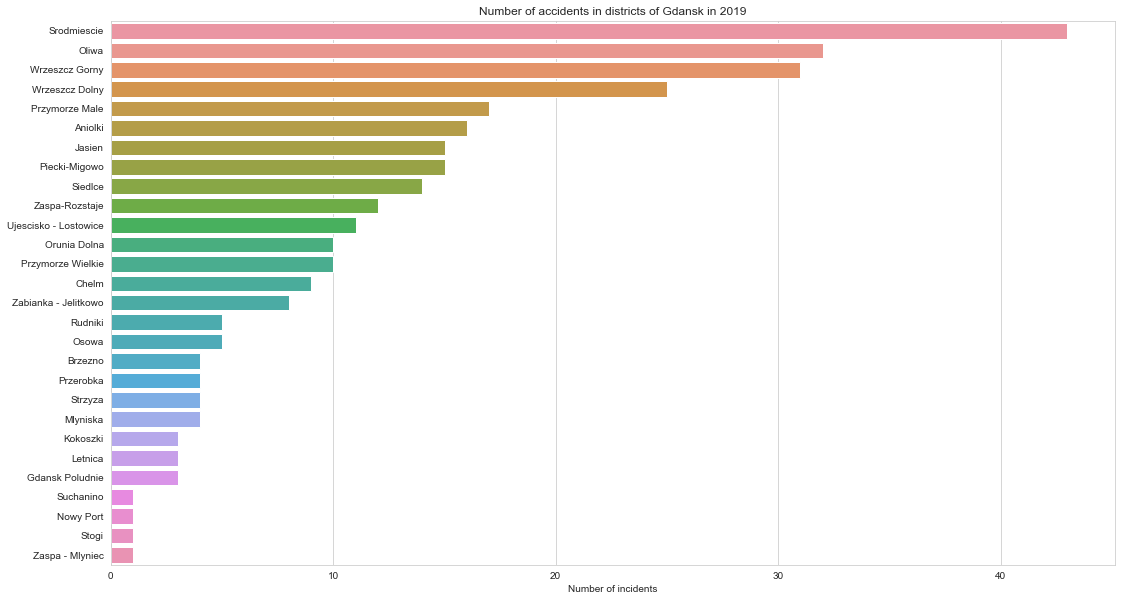

In [28]:
plt.title("Number of accidents in districts of Gdansk in 2019")
sns.barplot(data = gdansk_acc, y = gdansk_acc.index, x = gdansk_acc.District, orient='h', ci=None)
plt.xlabel('Number of incidents')
plt.show()

## Cracow

In [29]:
accidents_cracow = cracow[['lat','lon']].values.tolist()

In [30]:
districts_cracow = gpd.read_file('data/cracow/dzielnice/dzielnice_Krakowa.shp')
districts_cracow = districts_cracow.to_crs(epsg=4326)

In [31]:
for x in range(0,districts_cracow.shape[0]):
    districts_cracow.loc[x,'accidents'] = cracow[cracow.District==f'{districts_cracow.loc[x,"nazwa"]}'].shape[0]

In [32]:
districts_cracow['id'] = districts_cracow.index

In [33]:
districts_cracow_count_colormap = linear.YlGnBu_09.scale(min(districts_cracow.accidents), max(districts_cracow.accidents))

In [34]:
style_function_cracow = lambda x: {
    'fillColor': districts_cracow_count_colormap(x['properties']['accidents']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

In [35]:
cracow_measurement = pd.read_csv('data/cracow/measurment_points.csv')

In [36]:
map_cracow = fl.Map([50.05436, 19.92657], zoom_start=11.5, tiles='cartodbpositron')
       
# districts
fl.GeoJson(districts_cracow, name='Districts',
        style_function = style_function_cracow,
        tooltip=fl.GeoJsonTooltip(
        fields=['nazwa','accidents'],
        aliases=['District:', 'Accidents:'],
        localize=True
    )
          ).add_to(map_cracow)

for point in range(0,len(accidents_cracow)):
    fl.CircleMarker(location=accidents_cracow[point],popup=accidents_cracow[point],radius=1,fill=False,color="crimson").add_to(map_cracow)

fl.TileLayer('cartodbpositron').add_to(map_cracow)
fl.TileLayer('openstreetmap').add_to(map_cracow)
fl.TileLayer('Stamen Terrain').add_to(map_cracow)
fl.TileLayer('stamenwatercolor').add_to(map_cracow)
fl.LayerControl().add_to(map_cracow)
districts_cracow_count_colormap.add_to(map_cracow)
districts_cracow_count_colormap.caption = 'Accidents'
districts_cracow_count_colormap.add_to(map_cracow)
map_cracow

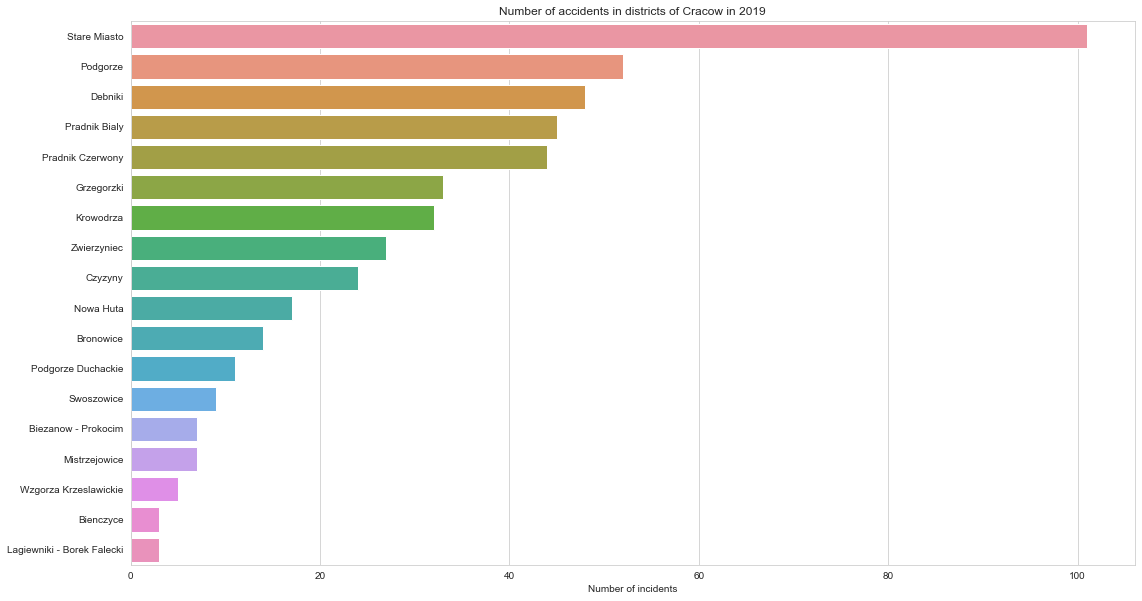

In [37]:
plt.title("Number of accidents in districts of Cracow in 2019")
sns.barplot(data = cracow_acc, y = cracow_acc.index, x = cracow_acc.District, orient='h', ci=None)
plt.xlabel('Number of incidents')
plt.show()

Comparison accidents in Cities

In [38]:
pd.DataFrame(data.City.value_counts())

,City
Cracow,482
Gdansk,307


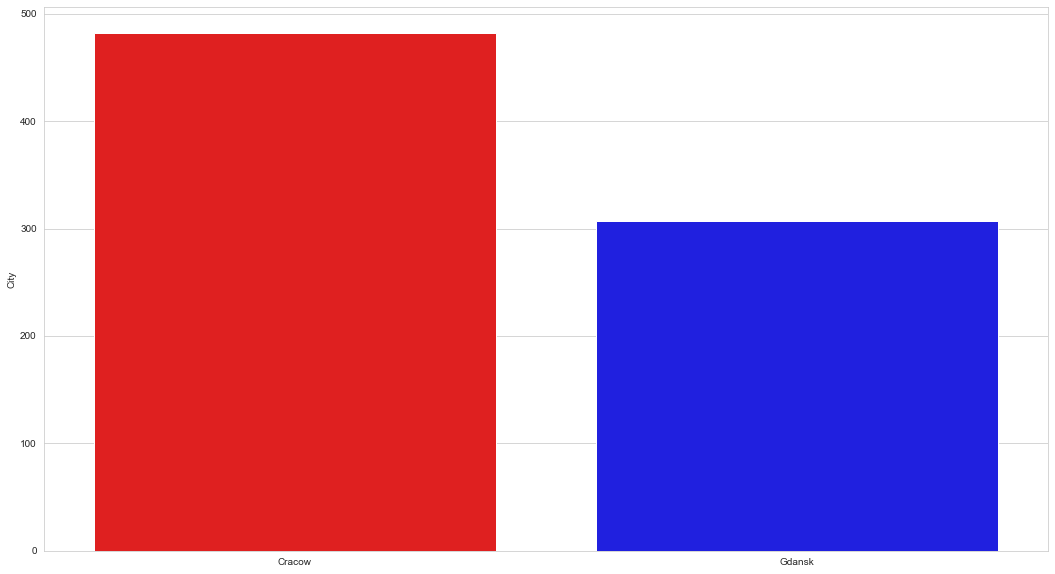

In [39]:
_=sns.barplot(pd.DataFrame(data.City.value_counts()).index,pd.DataFrame(data.City.value_counts()).City, palette=['red','blue'])

In [40]:
data.columns

Index(['Time', 'Adress', 'City', 'lon', 'lat', 'Place_of_the_incident',
       'Type_of_incident', 'ucz1', 'ucz1_plec', 'ucz1_pod_wplywem', 'Ucz1DOB',
       'ucz2', 'ucz2_plec', 'ucz2_pod_wplywem', 'Ucz2DOB', 'District', 'rok',
       'miesiac', 'dzien', 'godzina', 'dzien_tyg', 'dzien_tyg_name'],
      dtype='object')

In [41]:
acc_total = pd.DataFrame(data.value_counts(subset=['Place_of_the_incident','Type_of_incident','City','District'], sort=True)).reset_index()

In [42]:
for i in range(0,len(acc_total)):
    if acc_total.loc[i,'City'] == 'Gdansk':
        acc_total.loc[i,'Place'] = acc_total.loc[i,'Place_of_the_incident']-.1
    else:
        acc_total.loc[i,'Place'] = acc_total.loc[i,'Place_of_the_incident']+.1

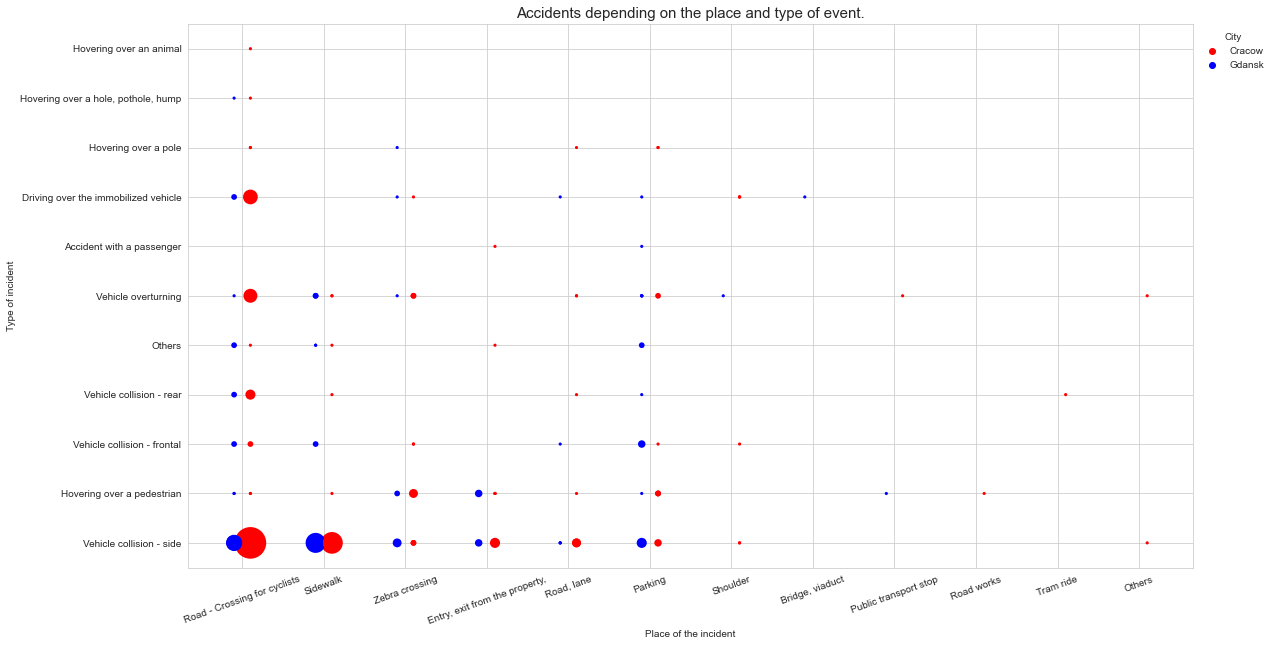

In [43]:
ax=sns.scatterplot(data=acc_total, x="Place", y="Type_of_incident", size = acc_total[0],  hue ='City', sizes=(10, 1000), marker="o", palette=['red','blue'],linewidth=0)
plt.title('Accidents depending on the place and type of event.', fontsize=15)
plt.ylabel('Type of incident')
plt.xlabel('Place of the incident')
plt.xticks(range(1,13),rotation=20,labels=['Road - Crossing for cyclists','Sidewalk','Zebra crossing','Entry, exit from the property,','Road, lane','Parking','Shoulder','Bridge, viaduct','Public transport stop','Road works','Tram ride','Others'])

plt.yticks(range(1,12),labels=['Vehicle collision - side','Hovering over a pedestrian','Vehicle collision - frontal','Vehicle collision - rear','Others','Vehicle overturning','Accident with a passenger','Driving over the immobilized vehicle','Hovering over a pole','Hovering over a hole, pothole, hump','Hovering over an animal'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3],title='City',loc='upper left', ncol=1,frameon=False, bbox_to_anchor=(1,1))
plt.show()

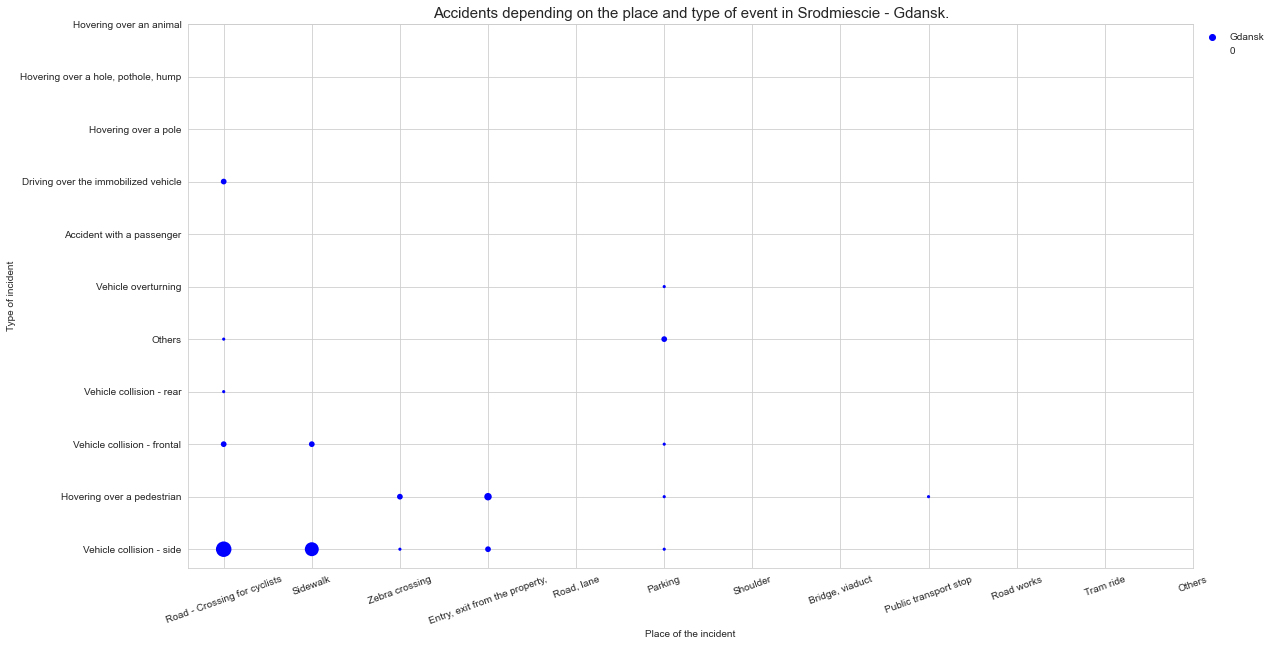

In [44]:
ax = sns.scatterplot(data = acc_total[(acc_total.City == 'Gdansk') & (acc_total.District == 'Srodmiescie')], 
                     x = "Place_of_the_incident", 
                     y = "Type_of_incident", 
                     hue = 'City',
                     palette = ['blue'],
                     size = acc_total[0], 
                     sizes=(10, 1000), 
                     marker="o", 
                     linewidth=0)
plt.title('Accidents depending on the place and type of event in Srodmiescie - Gdansk.', fontsize=15)
plt.ylabel('Type of incident')
plt.xlabel('Place of the incident')
plt.xticks(range(1,13),rotation=20,labels=['Road - Crossing for cyclists','Sidewalk','Zebra crossing','Entry, exit from the property,','Road, lane','Parking','Shoulder','Bridge, viaduct','Public transport stop','Road works','Tram ride','Others'])

plt.yticks(range(1,12),labels=['Vehicle collision - side','Hovering over a pedestrian','Vehicle collision - frontal','Vehicle collision - rear','Others','Vehicle overturning','Accident with a passenger','Driving over the immobilized vehicle','Hovering over a pole','Hovering over a hole, pothole, hump','Hovering over an animal'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3], loc='upper left', ncol=1,frameon=False, bbox_to_anchor=(1,1))
plt.show()

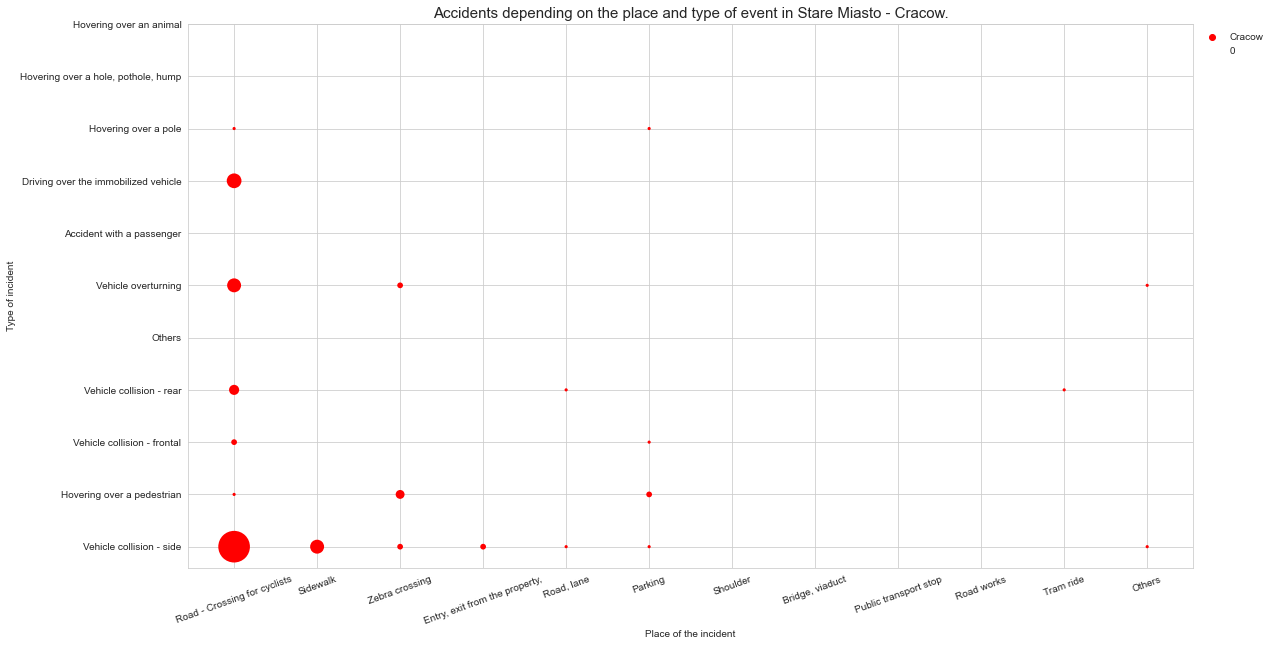

In [45]:
ax = sns.scatterplot(data = acc_total[(acc_total.City == 'Cracow') & (acc_total.District == 'Stare Miasto')], 
                     x = "Place_of_the_incident", y="Type_of_incident", 
                     hue = 'City',
                     size = acc_total[0],
                     palette=['red'], 
                     sizes=(10, 1000), 
                     marker="o", 
                     linewidth=0)
plt.title('Accidents depending on the place and type of event in Stare Miasto - Cracow.', fontsize=15)
plt.ylabel('Type of incident')
plt.xlabel('Place of the incident')
plt.xticks(range(1,13),rotation=20,labels=['Road - Crossing for cyclists','Sidewalk','Zebra crossing','Entry, exit from the property,','Road, lane','Parking','Shoulder','Bridge, viaduct','Public transport stop','Road works','Tram ride','Others'])

plt.yticks(range(1,12),labels=['Vehicle collision - side','Hovering over a pedestrian','Vehicle collision - frontal','Vehicle collision - rear','Others','Vehicle overturning','Accident with a passenger','Driving over the immobilized vehicle','Hovering over a pole','Hovering over a hole, pothole, hump','Hovering over an animal'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3], loc='upper left', ncol=1,frameon=False, bbox_to_anchor=(1,1))
plt.show()